## <center>Eigenfunctions of the Laplace operator on the Koch snowflake</center>

We generate and plot a few eigenfunctions of the Laplace operator on a snowflake. 

The numerical computation of eigenvalues of differential operators is
usually performed via
 a discretization of the  operator to get 
a finite dimensional matrix approximation through finite differences,
finite elements, or any other numerical method. The spectrum of the
approximation is then taken as an approximation to the spectrum of the
original differential operator.

The properties of Laplacian eigenvalues and eigenfunctions have been investigated in many scientific
disciplines,  theory of acoustical, optical, and quantum waveguides, condensed
matter physics and quantum mechanics, quantum graphs, image processing, computer
graphics,  biology and more.

Nowadays,  eigenfunctions of the Laplace operator have applications in Data Science and Machine Learning,
for face recognition, clustering,  nonlinear image denoising and segmentation,  mapping of protein energy landscapes, and more.
A google search reveals more examples.

To get an idea of their properties,  we illustrate here how to compute the spectrum of the Laplace operator, $\Delta u=\lambda u,$ 
$$\Delta=\displaystyle\frac{\partial^2}{\partial x^2}+\displaystyle\frac{\partial^2}{\partial y^2},$$ 
on a bounded planar domain.

The bounded domain is represented by a binary np.array, with 0 inside the domain and 1 outside it.

In this example  we are starting with a black and white image of a Koch snowflake, i.e. the bounded domain is the planar domain whose boundary is a closed Koch curve. First we read this image and process it to get a binary array representing the snowflake domain, to be passed to the algorithm that computes the first K eigenvalues and eigenfunctions of the disretized Laplace operator.

In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import scipy.sparse
from scipy.sparse import linalg
from skimage import  (filters, io)
import plotly.graph_objs as go

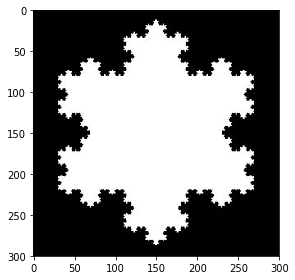

In [3]:
img=io.imread('images/kochSnowflake.jpg', as_gray=True)
io.imshow(img)

In [4]:
threshold = filters.threshold_otsu(img)
binary = img < threshold

Read the binary array representing a compact 2D region, and  perform the numerical discretization of the Helmholz equation $\Delta u=-\lambda u$ with Dirichlet boundary condition
 on this special domain.
 
For a better performance we are working with `scipy.sparse` matrices.

In [5]:
def discrete_Laplace(bimg):
    
    if bimg.shape[0] != bimg.shape[1]:
        raise ValueError('The code below works with arrays of shape (n,n)')
    vals = np.unique(bimg)  
    if len(vals) != 2 or 0 or 1 not in vals:
        raise ValueError('Your array is not binary')
    bimg = np.array(bimg, float)
    bimg = np.flipud(bimg)
    newimg = bimg + 1e-05 # a slight perturbation of the binary array
    n = newimg.shape[0]
    e = np.ones(n)
    diagonal_vals = np.array([-e, e, -e])
    partial_x = scipy.sparse.spdiags(diagonal_vals, np.array([-1, 0, n-1]), n, n)

    gradient = scipy.sparse.vstack([scipy.sparse.kron(partial_x, scipy.sparse.eye(n)), 
                                    scipy.sparse.kron(scipy.sparse.eye(n), partial_x)])

    img_as_row = np.concatenate((newimg.flatten(), newimg.flatten()))
    Laplace = gradient.transpose()*scipy.sparse.spdiags(img_as_row, [0], 2*n**2, 2*n**2)*gradient 
    return Laplace

Compute the K smalllest eigenvalues and eigenfunctions of the Laplace operator, [https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html),  with shift-invert mode corresponding to `sigma`=0.
In this case the transformed eigenvalues are `eigvals'=1/(eigvals-sigma)=1/eigvals`.
With the option `which='LM'` we get the k largest `eigvals'`, i.e.  the smallest 
eigenvalues of the original problem.

`Laplace.todense()` is a symmetric positive matrix of dimension $n^2 \times n^2$. The eigenvalues of the Laplace matrix  are ordered as follows:

$$0\leq\lambda_0\leq \lambda_1 \leq \cdots \lambda_{n^2-1}$$

In [6]:
def Laplace_spectrum(Laplace, K):
    return  scipy.sparse.linalg.eigsh(Laplace, K, which='LM', sigma=0) #eigvals, u    

In [17]:
def get_plotly_contour(u, bimg,   I, size=0.1, colorscale = 'RdBu', reversescale=False):
    # u: eigenfunction to be plotted
    # bimg: binary array representing the bounded domain on which the Laplace spectrum is computed image
    # I: index of the eigenvalue whose eigenfunction is plotted
    # size:  step for  contour lines
    if I >= u.shape[1]:
        raise ValueError(f'You must compute first at least {I+1} eigenvalues and eigenfunctions')
    n = bimg.shape[0]    
    uu = u[:, I].reshape((n, n)) #reshape the I^th eigenvector to create a contour trace from it
    uu = uu / np.max(np.fabs(uu)) # normalize the image representing the eigenfunction u[:,I]
    uu[bimg==1] = np.nan
    comin, comax = np.nanmin(uu), np.nanmax(uu)
    lim = max([abs(comin), comax])  #-lim, lim are the  start, and end values for the contour lines 
    return go.Contour(
                    z=uu.tolist(), 
                    colorscale=colorscale,
                    reversescale=reversescale,
                    colorbar=dict(thickness=20), 
                    contours=dict(start=-lim, end=lim, size=size),
                    line=dict(width=0.5, color='rgb(200,200,200)'))

In [18]:
pl_RdYlBu = [[0.0, 'rgb(49, 54, 149)'],
            [0.1, 'rgb(68, 115, 179)'],
            [0.2, 'rgb(116, 173, 209)'],
            [0.3, 'rgb(169, 216, 232)'],
            [0.4, 'rgb(224, 243, 248)'],
            [0.5, 'rgb(254, 254, 190)'],
            [0.6, 'rgb(254, 224, 144)'],
            [0.7, 'rgb(252, 172, 96)'],
            [0.8, 'rgb(244, 109, 67)'],
            [0.9, 'rgb(214, 47, 38)'],
            [1.0, 'rgb(165, 0, 38)']]


In [39]:
layout = go.Layout(title='',
                   font=dict(family='Balto',
                             size=12),
                   width=600, height=600, 
                   xaxis=dict(visible=False), 
                   yaxis=dict(visible=False),
                   plot_bgcolor='rgb(0, 101, 93)')


Let us compute 26 eigenvalues and the corresponding eigenfunctions of the Laplace operator defined on the snowflake.

In [45]:
K = 26
I = 25 

Laplace = discrete_Laplace(binary)
n = binary.shape[0]
eigvals, u = Laplace_spectrum(Laplace, K)
contour = get_plotly_contour(u, binary, I, size =0.07, colorscale = pl_RdYlBu)
fw = go.FigureWidget(data=[contour], layout=layout)
title = f"Eigenfunction of the Laplace operator defined on the snowflake<br>"+\
        f"Corresponding  eigenvalue: eig[{I}]={eigvals[I]:0.11f}"
fw.layout.update(title=title);

In [50]:
from IPython.display import IFrame
IFrame('https://plot.ly/~empet/15205',  width=600, height=600)